In [5]:
import numpy as np
import scipy.stats as ss
import seaborn as sns

# We set a seed so that the results are reproducible.
np.random.seed(5)

# number of samples.
n = 100

# true parameter.
λ_true = 2

# sample array.
y = np.random.poisson(lam=λ_true, size=n)

y

array([2, 4, 1, 0, 2, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 4, 2, 0, 0, 3, 6,
       1, 2, 1, 2, 5, 2, 3, 0, 1, 3, 1, 4, 1, 2, 4, 0, 6, 4, 1, 2, 2, 0,
       1, 2, 4, 4, 1, 3, 0, 3, 3, 2, 4, 2, 2, 1, 1, 2, 5, 2, 3, 0, 1, 1,
       1, 3, 4, 1, 3, 4, 2, 1, 2, 4, 2, 2, 1, 0, 2, 2, 3, 0, 3, 3, 4, 2,
       2, 1, 2, 1, 3, 0, 1, 0, 3, 3, 1, 2])

In [6]:
# mean of the sample.
y.mean()

2.06

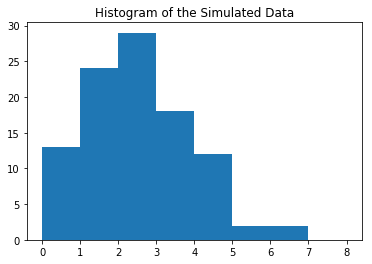

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Histogram of the sample.
plt.hist(y, bins=[0,1,2,3,4,5,6,7,8], density=False)
plt.title('Histogram of the Simulated Data')
plt.show()

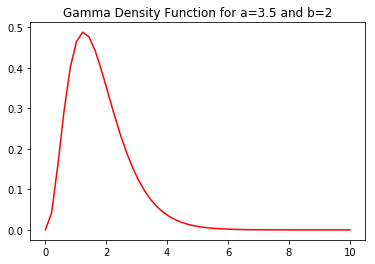

In [22]:
# Parameters of the prior gamma distribution.
a = 3.5  # shape
b = 2    # rate = 1/scale

x = np.linspace(0,10)
plt.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), 'r-')
plt.title(f'Gamma Density Function for a={a} and b={b}')
plt.show()

# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

In [28]:
import scipy.special as sp

# Define the likelihood function.
def likelihood(λ, y):
    
    factorials = np.apply_along_axis(lambda x: sp.gamma(x+1),
                                     axis=0,
                                     arr=y)
    
    numerator = np.exp(-λ*y.size) * (λ**y.sum())
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator/denominator  

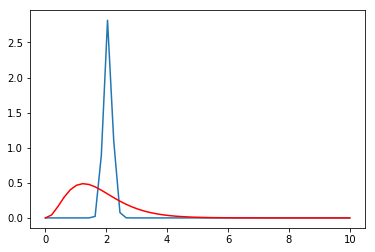

In [49]:
# Define the posterior distribution.
# (up to a constant)
def posterior_up_to_constant(λ, y):
    return likelihood(λ, y) * prior(λ)

# Plot of the prior and (scaled) posterior distribution
# for the parameter lambda.
#
# We multiply the posterior distrubution function
# by the amplitude factor 2.5e74 to make it comparable
# with the prior gamma distribution.
plt.plot(x, posterior_up_to_constant(x, y)/np.trapz(posterior_up_to_constant(x,y), x))
plt.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), 'r-')
plt.show()

## Bayesian linear regression

* Interested in 'Gibbs sampling' for normal linear regression with one independent variable.
* Assume that we have paired data $(y_i, x_i)$
* We want to find the posterior distribution for $\beta_0$ and $\beta_1$ and the variance component $1/ \tau$

### Model

* $y_i \sim \mathcal{N}(\beta_0 + \beta_1x_i, 1/\tau)$
* For the statisticians, this is equivalent to $y_i = \beta_0 + \beta_1x_i + \epsilon$
* The likelihood can be written as $$ \mathcal{L}(\beta_0, \beta_1, \tau \mid X) = \prod_{i=1}^N \mathcal{N}(\beta_0 + \beta_1x_i, 1/\tau)$$
* In Bayesian inference, we choose priors for $\beta_0, \beta_1, \tau$.
* These priors must be conjugate for Gibbs sampling, so for ease we only consider 

$$\beta_0 \sim \mathcal{N}(\mu_0, 1/\tau_0)$$ $$\beta_1 \sim \mathcal{N}(\mu_1, 1/\tau_1)$$ $$\tau \sim \text{Gamma}(\alpha, \beta)$$

## Gibbs sampling

Suppose we have two parameters $\beta_0$ and $\beta_1$ and some data $x$. We want to find the posterior distribution of $p(\beta_0, \beta_1 \mid x)$. Gibbs sampling lets us find the posterior joint distribution if we know the conditional distributions $p(\beta_0 \mid \beta_1, x)$ and $p(\beta_1 \mid \beta_0, x)$ (these are typically easier to find).

### Algorithm

1. Pick initial $\beta_1^{(i)}$
2. Sample $\beta^{(i+1)}_0 \sim p(\beta_0 \mid \beta_1^{(i)}, x)$
3. Sample $\beta_1^{(i+1)} \sim p(\beta_1 \mid \beta_0^{(i+1)}, x)$

We keep repeating to draw more samples. 

* A positive recurrent Markov chain that is both irreducible and aperiodic always has a stationary distribution.

This works, if you want to see how it works read Casella and George (1990)

* The advantage of Gibbs over Metropolis-Hastings is that no tuning is required
* There are more sophisticated packages out there to fit complex models e.g. PyMC3 and Stan

In [52]:
import numpy as np

%matplotlib inline
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

In [53]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [54]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [55]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

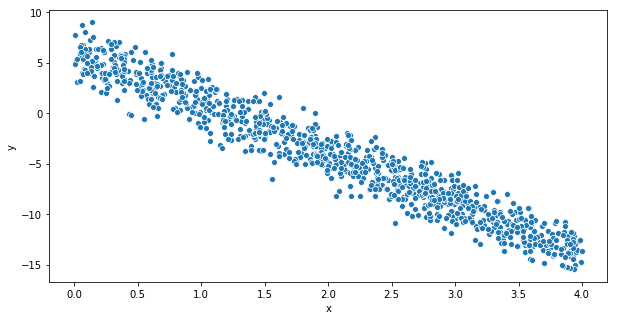

In [205]:
beta_0_true = 6
beta_1_true = -5
tau_true = 0.5

N = 1000
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

ax = sns.scatterplot(x, y)
ax.set(xlabel='x', ylabel='y')
plt.show()

In [206]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": -5,
        "tau": 4}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [207]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [208]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)

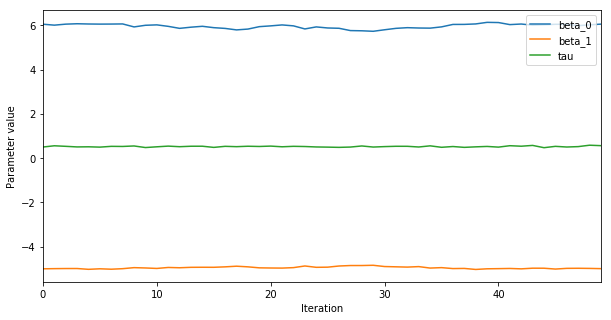

In [209]:
traceplot = trace[0:50].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

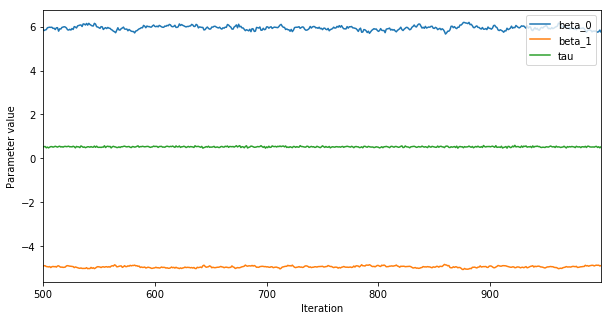

In [210]:
traceplot = trace[500:1000].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

In [211]:
trace[100:].mean()

beta_0    5.934769
beta_1   -4.952375
tau       0.521372
dtype: float64

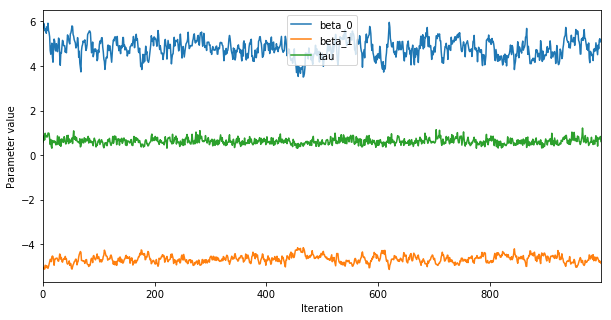

beta_0    4.776301
beta_1   -4.652789
tau       0.617740
dtype: float64

In [213]:
beta_0_true = 6
beta_1_true = -5
tau_true = 0.5

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

iters = 1000
trace = gibbs(y, x, iters, init, hypers)

traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
plt.show()

trace[100:].mean()

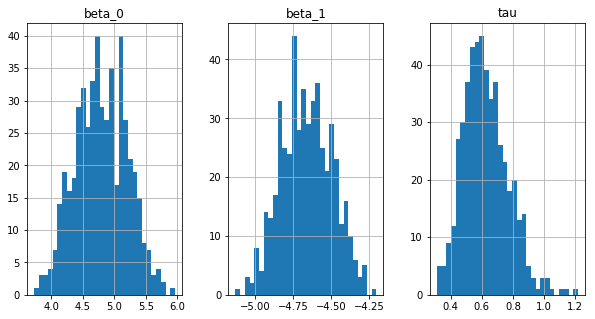

In [214]:
hist_plot = trace[500:1000].hist(bins = 30, layout = (1,3))

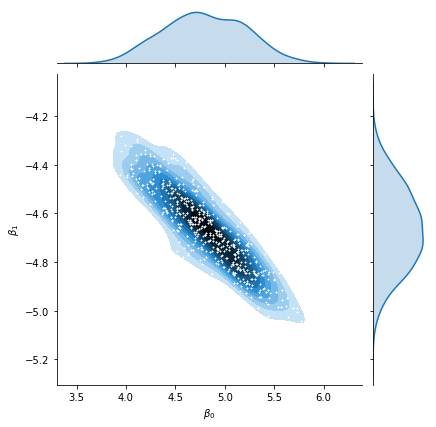

In [393]:
ax = sns.jointplot(x='beta_0', y = 'beta_1', data=trace[500:1000], kind='kde', colour='m')
ax.plot_joint(plt.scatter, c="w", s=5, linewidth=1, marker="+")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels(r"$\beta_0$", r"$\beta_1$");

Note: If we place a Laplace (double exponential) prior on the $\beta$'s we get the penalised linear regression model with lasso penalty.

Let's say we observe some data where $X$ are the variables and $y$ is the target.

$$\mathcal{D} = \{(\mathbf{x}_i, y_i\}_{i=1}^{n} = (\mathbf{X},y)$$

We want to model our data as

$$y_i = f(x_i) + \epsilon_i$$

where $f \sim GP(0,K)$ and $\epsilon \sim N(0, \sigma^2)$

We place a prior on $f$ (a prior of functional forms). The Likelihood is Gaussian therefore the posterior is a GP.



Source: http://mlss2011.comp.nus.edu.sg/uploads/Site/lect1gp.pdf

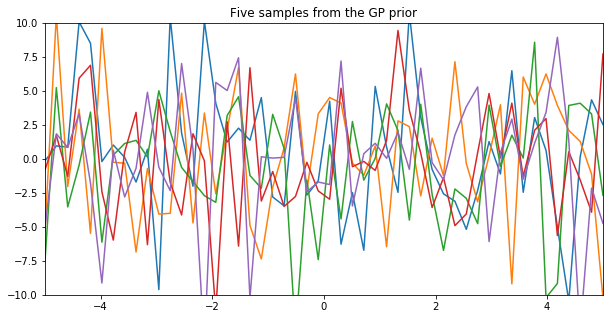

In [497]:
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b):
    return 20.0*RBF(length_scale=0.01, length_scale_bounds=(1e-2, 1e3)).__call__(a, b)

param = 0.1
K_ss = kernel(Xtest, Xtest)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss)
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,5)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -10, 10])
plt.title('Five samples from the GP prior')
plt.show()

In [499]:
from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
gpr.score(X, y), gpr.predict(X[:2,:], return_std=True) 

(0.36802938610173963,
 (array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679])))

In [536]:
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston['data']
y = boston['target']

In [537]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [538]:
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)

In [541]:
gpr.score(X_test,y_test), np.mean((gpr.predict(X_test) - y_test)**2)

(0.709079688871838, 22.01641520143611)

In [549]:
kernel = C()*RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)

In [550]:
gpr.score(X_test,y_test), np.mean((gpr.predict(X_test) - y_test)**2)

(0.8311264160635224, 12.780100935826846)

In [243]:
y_pred, y_std = gpr.predict(X, return_std=True)

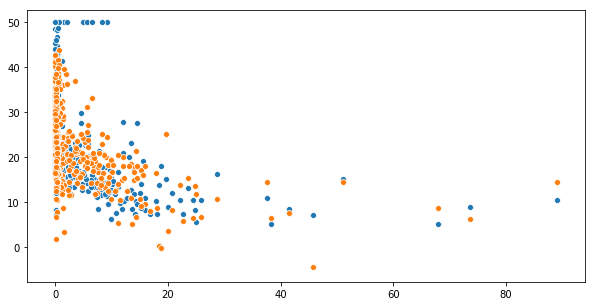

In [248]:
sns.scatterplot(X[:,0], y)
sns.scatterplot(X[:,0], y_pred)

In [474]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):
    """The function to predict."""
    return 1.2*x**2 - 12*x + 2 + 20*np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# kernel = DotProduct() + WhiteKernel()
# kernel = 1.0 * RBF(10, (1e-2, 1e2))
kernel = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
    WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# # Observations
# y = f(X).ravel()

# # Mesh the input space for evaluations of the real function, the prediction and
# # its MSE


# # Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# # Fit to data using Maximum Likelihood Estimation of the parameters
# gp.fit(X, y)

# # Make the prediction on the meshed x-axis (ask for MSE as well)
# y_pred, sigma = gp.predict(x, return_std=True)

# # Plot the function, the prediction and the 95% confidence interval based on
# # the MSE
# plt.figure()
# plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
# plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
# plt.plot(x, y_pred, 'b-', label=u'Prediction')
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([y_pred - 1.9600 * sigma,
#                         (y_pred + 1.9600 * sigma)[::-1]]),
#          alpha=.5, fc='b', ec='None', label='95% confidence interval')
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
# plt.legend(loc='upper left')

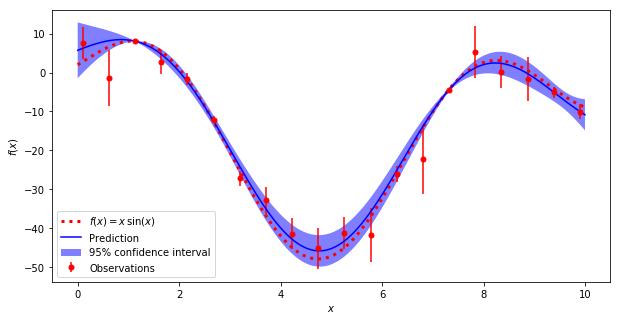

In [475]:
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 10 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$', linewidth=3)
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
plt.legend(loc='lower left')

plt.show()

/usr/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


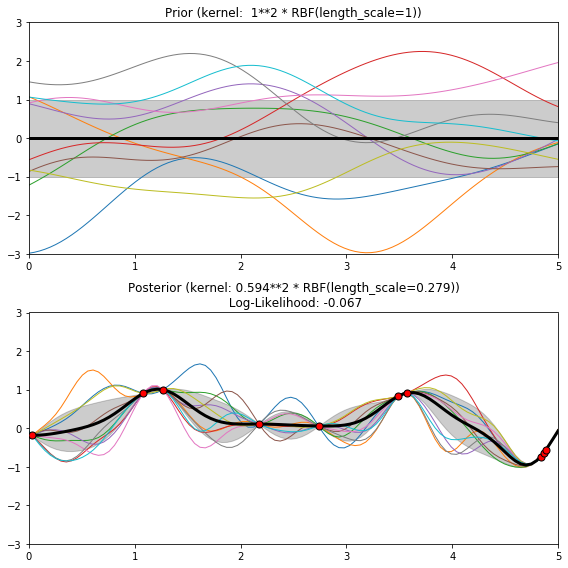

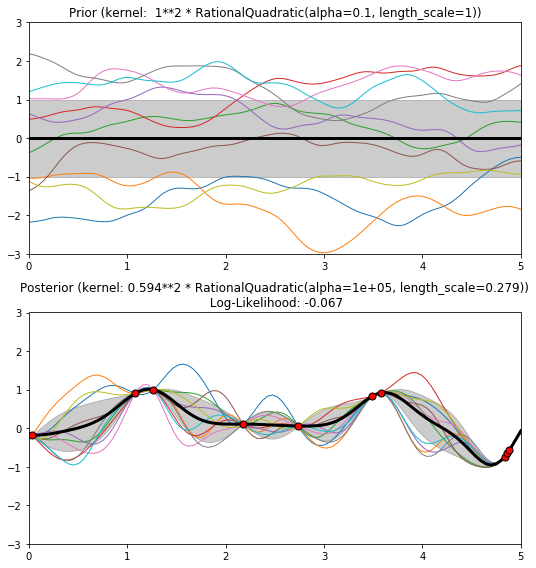

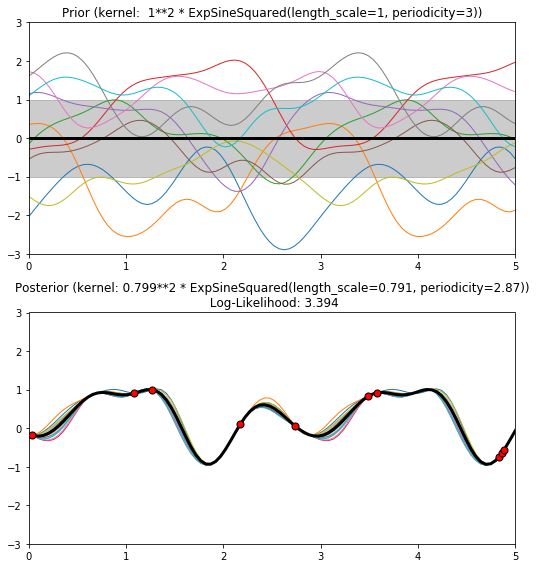

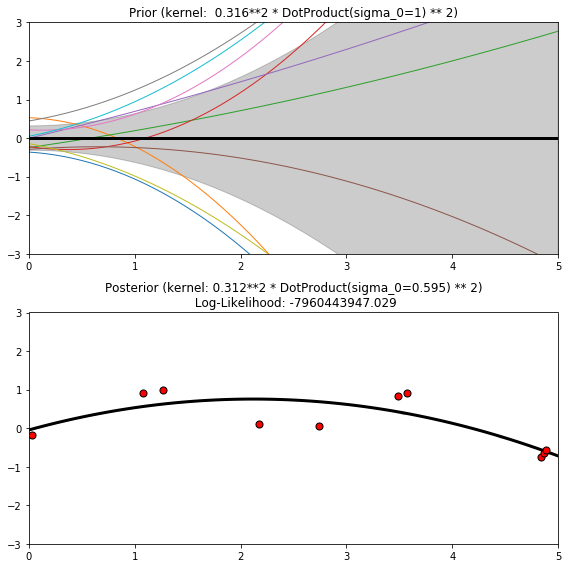

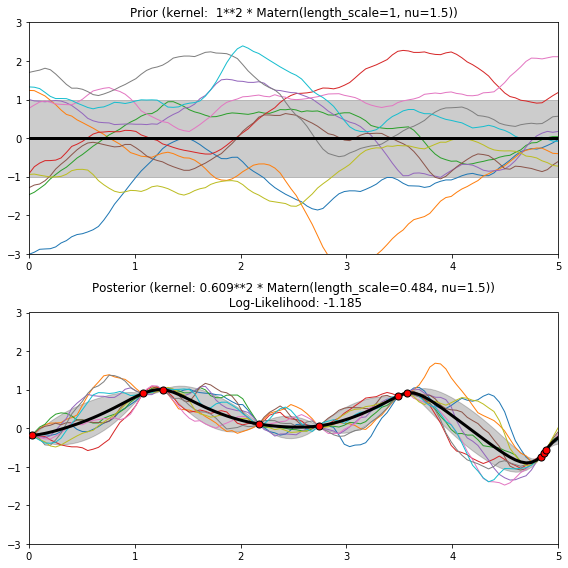

In [477]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()


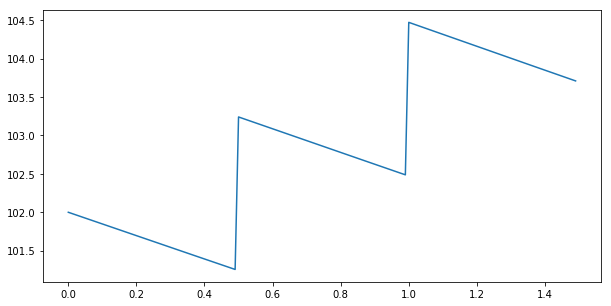

In [330]:
x = np.arange(0, 1.5, 0.01)

plt.plot(x, [p(0.04,0.015,T) for T in x])

In [335]:
p(0.04, 0.015, 1.01)
p(0.04, 0.015, 0.99)

102.48746825013806

In [336]:
def p1(c, y, T):
    if T>= 1:
        return (2-2*T)*(100*(c/2))/((1+y/2)**(2*T-1)) + (1-2*T)*100*(c/2)/((1+y/2)**(2*T)) - 2*T*(100*(c/2) + 100)/((1+y/2)**(2*T+1))

In [337]:
p1(0.04, 0.015, 5/4)

-252.35100720451692